# [Module 4.1] 세이지 메이커 배포 및 인퍼런스

본 워크샵의 모든 노트북은 `conda_python3` 추가 패키지를 설치하고 모두 이 커널 에서 작업 합니다.

- 1. 배포 준비
- 2. 로컬 앤드포인트 생성
- 3. 로컬 추론

## 참고:

- 세이지 메이커의 모델 배포 및 추론 Python SDK 가이드.
    - [Deploying directly from model artifacts](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html#deploying-directly-from-model-artifacts)



---    
    

# 1. 배포 준비

이전 노트북에서 인퍼런스 테스트를 완료한 티펙트를 가져옵니다.

In [1]:
%store 

Stored variables and their in-db values:
data_dir                               -> 'data'
eval_dir                               -> 'data/cifar10/eval'
keras_script_artifact_path             -> 's3://sagemaker-us-east-1-057716757052/cifar10-202
tf2_horovod_artifact_path              -> 's3://sagemaker-us-east-1-057716757052/cifar10-tf-
train_dir                              -> 'data/cifar10/train'
validation_dir                         -> 'data/cifar10/validation'


In [2]:
%store -r tf2_horovod_artifact_path
%store -r keras_script_artifact_path


## 모델 아티펙트 지정

- 앞에서 실행하여 생성된 모델 아티펙트의 경로를 지정 함.
- 주석을 제거하시고 사용하시면 됨.

In [3]:
# artifact_path = tf2_horovod_artifact_path
artifact_path = keras_script_artifact_path

In [5]:
print("artifact_path: ", artifact_path)

artifact_path:  s3://sagemaker-us-east-1-057716757052/cifar10-2021-10-10-13-29-58-651/output/model.tar.gz


In [10]:
import sagemaker
import os
import time


sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"

role = sagemaker.get_execution_role()

# 2. 모델 배포 준비

- 앞에 노트북에서 도커 이미지를 다운로드하여서 용량이 부족할 수 있기에, 용량 부족시 실행함.

## 시스템의 이전 도커 컨테이너 삭제
- 아래와 같은 명령어를 사용하여 저장 공간을 확보 합니다.

In [7]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        241G   80K  241G   1% /dev
tmpfs           241G     0  241G   0% /dev/shm
/dev/xvda1      109G  107G  1.9G  99% /
/dev/xvdf       984G   25G  910G   3% /home/ec2-user/SageMaker


In [8]:
# ! docker container prune -f 
# ! rm -rf /tmp/tmp*
# ! df -h

In [9]:
# ! df -h
# ! docker image prune -f --all
# ! df -h

# 3. 세이지 메이커 로컬 엔드포인트 생성
- 이 과정은 세이지 메이커 엔드포인트를 생성합니다.



In [11]:
from sagemaker.tensorflow import TensorFlowModel

sm_tf_model = TensorFlowModel(
                        model_data= artifact_path,
                        framework_version='2.4.1',
                        #py_version='py37',    
                        role=role,
        )

instance_type = 'local_gpu'
endpoint_name = "sm-endpoint-cifar10-tf2-{}".format(int(time.time()))

sm_tf_predictor = sm_tf_model.deploy(
                           instance_type= instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                        )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Attaching to 78g8dzbn7m-algo-1-yakwt
78g8dzbn7m-algo-1-yakwt | INFO:__main__:PYTHON SERVICE: False
78g8dzbn7m-algo-1-yakwt | INFO:__main__:starting services
78g8dzbn7m-algo-1-yakwt | INFO:__main__:using default model name: model
78g8dzbn7m-algo-1-yakwt | INFO:__main__:tensorflow serving model config: 
78g8dzbn7m-algo-1-yakwt | model_config_list: {
78g8dzbn7m-algo-1-yakwt |   config: {
78g8dzbn7m-algo-1-yakwt |     name: 'model'
78g8dzbn7m-algo-1-yakwt |     base_path: '/opt/ml/model'
78g8dzbn7m-algo-1-yakwt |     model_platform: 'tensorflow'
78g8dzbn7m-algo-1-yakwt |     model_version_policy: {
78g8dzbn7m-algo-1-yakwt |       specific: {
78g8dzbn7m-algo-1-yakwt |         versions: 1
78g8dzbn7m-algo-1-yakwt |       }
78g8dzbn7m-algo-1-yakwt |     }
78g8dzbn7m-algo-1-yakwt |   }
78g8dzbn7m-algo-1-yakwt | }
78g8dzbn7m-algo-1-yakwt | 
78g8dzbn7m-algo-1-yakwt | 
78g8dzbn7m-algo-1-yakwt | INFO:__main__:tensorflow version info:
78g8dzbn7m-algo-1-yakwt | 2021-10-10 13:55:38.464924: W external/

# 4. 로컬 추론: 샘플로 9개 만 추론
- 준비된 입력 데이터로 로컬 엔드포인트에서 추론

## 데이터 읽기 단계

- `data/cifar10/eval/eval-tfrecords` 일고  9 batch_size 로 할당하여, TF dataset를 생성 합니다.
- 1 개의 배치 (9개의 이미지, 레이블 포함) 를 읽음
- 1 개의 배치 추론

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils import _input, classes

batch_size = 9
sample_dir = 'data/cifar10/eval'
sample_dataset = _input(1, batch_size, sample_dir, 'eval')

## 추론 함수 정의

In [13]:
def predict(predictor, data):
    predictions = predictor.predict(data)['predictions']
    
    return predictions

## 9개의 이미지의 실제 값과 추론 값 보여주기

images shape:  (9, 32, 32, 3)


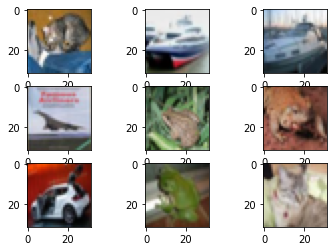

78g8dzbn7m-algo-1-yakwt | 172.18.0.1 - - [10/Oct/2021:13:56:12 +0000] "POST /invocations HTTP/1.1" 200 1350 "-" "python-urllib3/1.26.6"

Ground Truth:
  cat ship ship plane frog frog  car frog  cat
Predicted Labels:
  cat ship ship ship frog  cat  car deer  dog


In [14]:
import time
# 1개의 배치만을 가져옴
images, labels = iter(sample_dataset).next()
print("images shape: ", images.numpy().shape)

# 텐서를 numpy array 로 변경
images = images.numpy()
labels = labels.numpy()

# 이미지 한장 씩 보여주기, 레이블은 가장 값이 높은 인덱스를 구하기
ground_truth_labels = []
for i in range(batch_size):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(images[i])
    ground_truth_labels.append(np.argmax(labels[i]))
    
plt.show()

# 추론 하여 예측값 구하기
predictions = predict(sm_tf_predictor, images)

# 추론 값의 가장 값이 높은 인덱스 구하기
prediction_labels = []
for i, prediction in enumerate(predictions):
    prediction_labels.append(np.argmax(prediction))

time.sleep(1)    
print("\nGround Truth:\n", " ".join("%4s" % classes[ground_truth_labels[j]] for j in range(batch_size)))
print("Predicted Labels:\n", " ".join("%4s" % classes[prediction_labels[j]] for j in range(batch_size)))


# 5. 로컬 추론: 전체 테스트 세트 10,000 개 추론

In [15]:
batch_size = 1000
eval_dir = 'data/cifar10/eval'
eval_dataset = _input(1, batch_size, eval_dir, 'eval')

In [16]:
def inference_batch(predictor, eval_dataset):
    '''
    제공된 데이터 세트의 실제 레이블, 추론 레이블의 값을 제공
    '''
    ground_truth_labels = []
    prediction_labels = []

    for batch_id, (images, labels) in enumerate(eval_dataset):
        print(f"batch_id: {batch_id}  - images shape: {images.numpy().shape}")
        # 텐서를 numpy array 로 변경
        images = images.numpy()
        labels = labels.numpy()

        # 이미지 한장 씩 보여주기, 레이블은 가장 값이 높은 인덱스를 구하기

        for i in range(batch_size):
            ground_truth_labels.append(np.argmax(labels[i]))


        # 추론 하여 예측값 구하기
        predictions = predict(predictor, images)

        # 추론 값의 가장 값이 높은 인덱스 구하기

        for i, prediction in enumerate(predictions):
            prediction_labels.append(np.argmax(prediction))


    time.sleep(1)    

    print("ground_truth_labels: ", np.array(ground_truth_labels).shape)
    print("prediction_labels: ", np.array(prediction_labels).shape)
    
    return ground_truth_labels, prediction_labels



In [17]:
ground_truth_labels, prediction_labels = inference_batch(sm_tf_predictor, eval_dataset)

batch_id: 0  - images shape: (1000, 32, 32, 3)
78g8dzbn7m-algo-1-yakwt | 172.18.0.1 - - [10/Oct/2021:13:56:33 +0000] "POST /invocations HTTP/1.1" 200 146774 "-" "python-urllib3/1.26.6"
batch_id: 1  - images shape: (1000, 32, 32, 3)
78g8dzbn7m-algo-1-yakwt | 172.18.0.1 - - [10/Oct/2021:13:56:35 +0000] "POST /invocations HTTP/1.1" 200 146614 "-" "python-urllib3/1.26.6"
batch_id: 2  - images shape: (1000, 32, 32, 3)
78g8dzbn7m-algo-1-yakwt | 172.18.0.1 - - [10/Oct/2021:13:56:37 +0000] "POST /invocations HTTP/1.1" 200 146380 "-" "python-urllib3/1.26.6"
batch_id: 3  - images shape: (1000, 32, 32, 3)
78g8dzbn7m-algo-1-yakwt | 172.18.0.1 - - [10/Oct/2021:13:56:38 +0000] "POST /invocations HTTP/1.1" 200 146949 "-" "python-urllib3/1.26.6"
batch_id: 4  - images shape: (1000, 32, 32, 3)
78g8dzbn7m-algo-1-yakwt | 172.18.0.1 - - [10/Oct/2021:13:56:41 +0000] "POST /invocations HTTP/1.1" 200 146635 "-" "python-urllib3/1.26.6"
batch_id: 5  - images shape: (1000, 32, 32, 3)
78g8dzbn7m-algo-1-yakwt | 17

## 전체 정확도 구하기

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

def compute_accuracy(prediction_labels, ground_truth_labels):
    accuracy = accuracy_score(y_pred=prediction_labels,y_true=ground_truth_labels)
    display('Average accuracy: {}%'.format(round(accuracy*100,2)))
    
compute_accuracy(prediction_labels, ground_truth_labels)    

'Average accuracy: 62.71%'

## 전체 혼돈 매트릭스 구하기

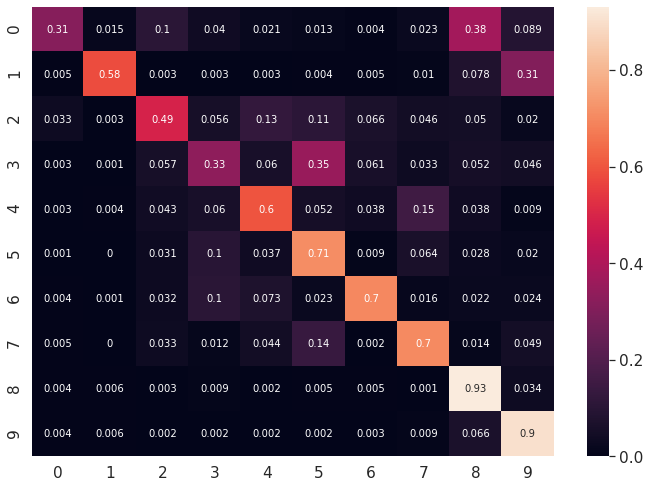

In [19]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def show_cm_matrix(prediction_labels, ground_truth_labels):
    cm = confusion_matrix(y_pred=prediction_labels,y_true=ground_truth_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sn.set(rc={'figure.figsize': (11.7,8.27)})
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(cm, annot=True, annot_kws={"size": 10})# font size
    
show_cm_matrix(prediction_labels, ground_truth_labels)    

## Clean-up

위의 엔드포인트를 삭제 합니다.

In [20]:
sm_tf_predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


# 6. 세이지 메이커 호스트 추론

- 아래는 약 10분 정도 소요 됩니다.

In [21]:
%%time 

from sagemaker.tensorflow import TensorFlowModel

sm_tf_model = TensorFlowModel(
                        model_data= artifact_path,
                        framework_version='2.4.1',
                        role=role,
        )

instance_type = 'ml.p2.xlarge'
endpoint_name = "sm-host-endpoint-cifar10-tf2-{}".format(int(time.time()))

sm_host_tf_predictor = sm_tf_model.deploy(
                           instance_type= instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                        )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------------!CPU times: user 379 ms, sys: 23.6 ms, total: 403 ms
Wall time: 9min 33s


In [22]:
%%time

ground_truth_labels, prediction_labels = inference_batch(sm_host_tf_predictor, eval_dataset)

batch_id: 0  - images shape: (1000, 32, 32, 3)
batch_id: 1  - images shape: (1000, 32, 32, 3)
batch_id: 2  - images shape: (1000, 32, 32, 3)
batch_id: 3  - images shape: (1000, 32, 32, 3)
batch_id: 4  - images shape: (1000, 32, 32, 3)
batch_id: 5  - images shape: (1000, 32, 32, 3)
batch_id: 6  - images shape: (1000, 32, 32, 3)
batch_id: 7  - images shape: (1000, 32, 32, 3)
batch_id: 8  - images shape: (1000, 32, 32, 3)
batch_id: 9  - images shape: (1000, 32, 32, 3)
ground_truth_labels:  (10000,)
prediction_labels:  (10000,)
CPU times: user 20.9 s, sys: 2.53 s, total: 23.4 s
Wall time: 37.8 s


In [23]:
compute_accuracy(prediction_labels, ground_truth_labels)    

'Average accuracy: 62.71%'

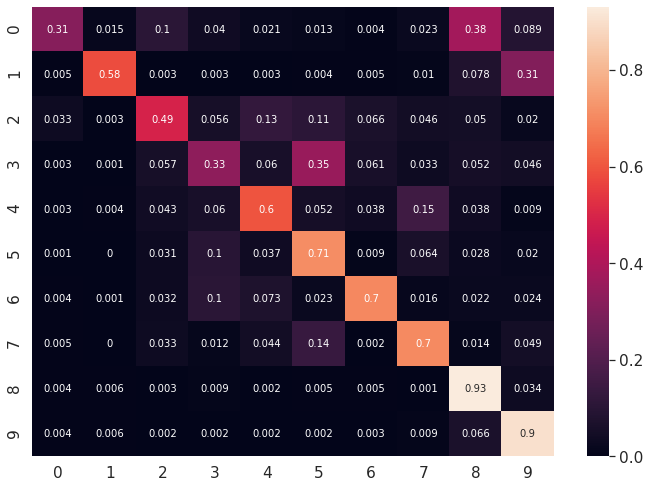

In [24]:
show_cm_matrix(prediction_labels, ground_truth_labels)    

# 7. 리소스 정리

In [25]:
sm_host_tf_predictor.delete_endpoint()